In [1]:
import pandas as pd
df = pd.read_csv('thrombin_pIC50')
df.head()

,smiles,pIC50,activity_label
0,NC(N)=NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...,11.769551,Active
1,CC(O)[C@@H](C(=O)N[C@H](C)c1ccccc1)N(C)C(=O)[C...,11.096910,Active
2,COc1cc(C(=O)N2CC(C)(CCO)OC[C@H]2C)cc2nc(N[C@@H...,11.000000,Active
3,CN[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)N[C@H](...,10.522879,Active
4,Cc1nc(N)ccc1CNC(=O)Cn1c(C)cnc(NCC(F)(F)c2ccccn...,10.376751,Active


In [2]:
df.activity_label.unique()

array(['Active', 'Inactive'], dtype=object)

In [3]:
df.shape

(1378, 3)

In [4]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import numpy as np

def generate_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=512)
        fp = mfpgen.GetFingerprint(mol)
        # Convert the fingerprint to a numpy array
        return np.array(fp)

    return None  # In case of invalid SMILES


df['fingerprint'] = df['smiles'].apply(generate_fingerprint)


In [5]:
df.activity_label.value_counts()

activity_label
Active      919
Inactive    459
Name: count, dtype: int64

In [6]:
active_count = 919
inactive_count = 459

ratio = active_count / inactive_count
print(f"Class ratio: {ratio:.2f}")  # → ~2.00

Class ratio: 2.00


If the ratio is significantly >1.0 or <1.0, your dataset is imbalanced

<Axes: ylabel='count'>

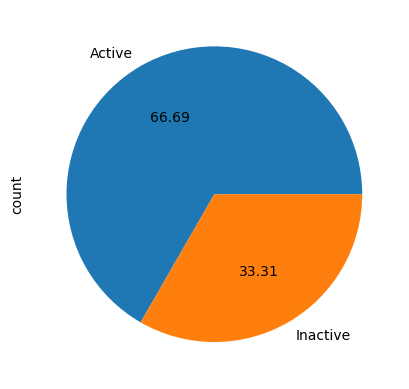

In [7]:
# Show pie plot (Approach 1)
df.activity_label.value_counts().plot.pie(autopct='%.2f')

In [8]:
# Map 'active' to 1 and 'inactive' to 0 for the 'activity_label' column
y = df['activity_label'].map({'Active': 1, 'Inactive': 0})

# Extract the fingerprints from the DataFrame
X = np.array(df['fingerprint'].tolist())  # Convert the list of fingerprints into a numpy array

# Now you can proceed with splitting and training the model

In [9]:
y.isna()

0       False
1       False
2       False
3       False
4       False
        ...  
1373    False
1374    False
1375    False
1376    False
1377    False
Name: activity_label, Length: 1378, dtype: bool

In [10]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: activity_label, dtype: int64

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Random Oversampling

LogisticRegression(max_iter=1000)

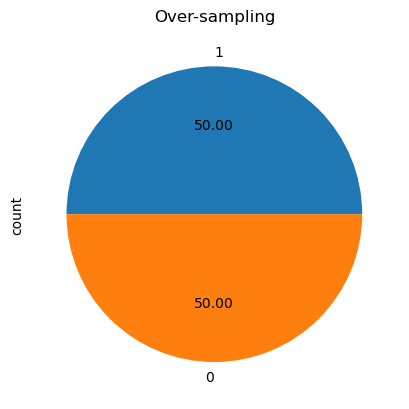

In [16]:
from imblearn.over_sampling import SMOTE
# Train a model on the SMOTE-resampled data
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to create synthetic samples for the minority class
smote = SMOTE(sampling_strategy="auto")
X_res_smote, y_res_smote = smote.fit_resample(X_train_smote, y_train_smote)
ax = y_res_smote.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling")

# Train the model
model = LogisticRegression(max_iter=1000)  # Or your trained model
model.fit(X_res_smote, y_res_smote)


In [18]:
# Predict with the trained model
y_pred_smote = model.predict(X_test_smote)

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       126
           1       0.91      0.92      0.92       288

    accuracy                           0.88       414
   macro avg       0.86      0.86      0.86       414
weighted avg       0.88      0.88      0.88       414



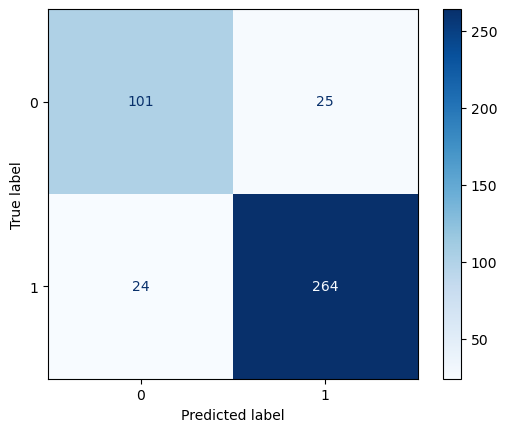

In [19]:
import joblib
# Save the trained model
joblib.dump(model, 'model_smote.pkl')  # Save the model to a file

# Evaluate the model
print(classification_report(y_test_smote, y_pred_smote))

# Confusion Matrix for SMOTE-based model
cm_smote = confusion_matrix(y_test_smote, y_pred_smote)
disp_smote = ConfusionMatrixDisplay(confusion_matrix=cm_smote, display_labels=model.classes_)
disp_smote.plot(cmap=plt.cm.Blues)
plt.show()

      Actual  Predicted
597        1          1
700        1          1
1222       0          0
1145       0          0
602        1          1
1078       0          0
65         1          1
745        1          1
478        1          1
67         1          1
453        1          1
571        1          1
904        1          1
572        1          1
939        0          0
1115       0          0
237        1          1
924        0          1
1187       0          1
303        1          1
481        1          1
1201       0          0
339        1          1
716        1          1
208        1          1
1235       0          0
1061       0          0
650        1          1
573        1          1
244        1          1
581        1          1
427        1          1
711        1          0
410        1          1
666        1          1
803        1          1
985        0          1
382        1          1
808        1          1
946        0          0
706        1    

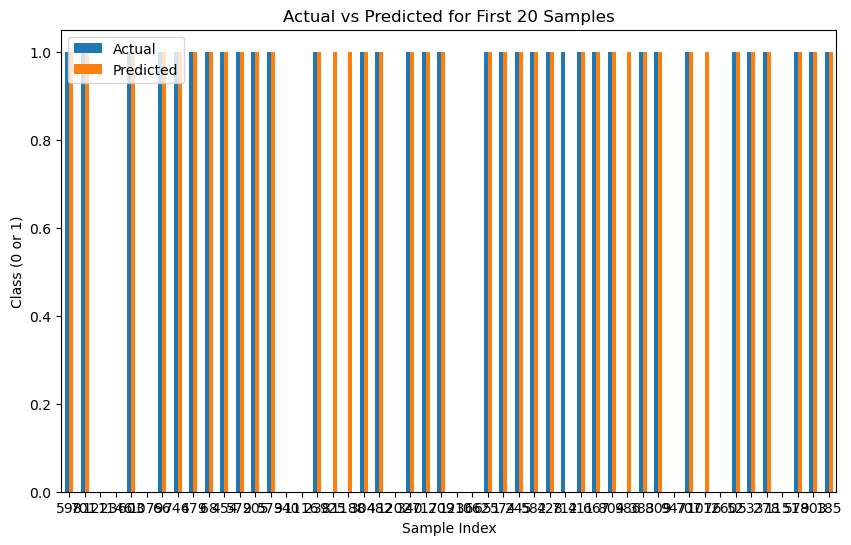

In [20]:
import pandas as pd

# Extract the first 20 actual and predicted values
comparison = pd.DataFrame({
    'Actual': y_test_smote[:50],  # First 20 actual values
    'Predicted': y_pred_smote[:50]  # First 20 predicted values
})

# Print the comparison table
print(comparison)

# Optionally, you can visualize this comparison with a bar chart
import matplotlib.pyplot as plt

# Create a bar plot to compare actual vs predicted for the first 20 samples
comparison_plot = comparison.set_index(comparison.index + 1)  # Adjust index for readability
comparison_plot.plot(kind='bar', figsize=(10, 6))
plt.title("Actual vs Predicted for First 20 Samples")
plt.xlabel("Sample Index")
plt.ylabel("Class (0 or 1)")
plt.xticks(rotation=0)
plt.show()
